# Geospatial data analysis of time series
Quinn Brencher

In [150]:
# Import required packages
import os
import numpy as np
import pandas as pd
import rasterio as rio
import matplotlib.pyplot as plt
import xarray as xr
import datetime as dt
import rioxarray
import seaborn as sns
import geopandas as gpd

## Load in and rebuild time series data

In [121]:
# functions to load in mintpy data

# function to rewrite coordinates from metadata
def coord_range(ds):
    latrange = np.linspace(float(ds.attrs['Y_FIRST']),
                           ((float(ds.attrs['Y_STEP'])*float(ds.attrs['LENGTH']))+float(ds.attrs['Y_FIRST'])),
                           int(ds.attrs['LENGTH']))
    lonrange = np.linspace(float(ds.attrs['X_FIRST']),
                           ((float(ds.attrs['X_STEP'])*float(ds.attrs['WIDTH']))+float(ds.attrs['X_FIRST'])),
                           int(ds.attrs['WIDTH']))
    return latrange, lonrange

# function to read time series into xarray
def mintpyTS_to_xarray(fn, crs):
    ds = xr.open_dataset(fn)
    ds = ds.rename_dims({'phony_dim_1':'time',
                         'phony_dim_2':'y',
                         'phony_dim_3':'x'})
    ds = ds.rename({'timeseries': 'displacement'})
    latrange, lonrange = coord_range(ds)
    ds = ds.assign_coords({'time': ('time', pd.to_datetime(ds.date)),
                           'y': ('y', latrange),
                           'x': ('x', lonrange)})
    ds = ds.drop(['bperp', 'date'])
    ds = ds.rio.write_crs(crs)
    
    return ds

def mintpy2d_to_xarray(fn, crs):
    ds = xr.open_dataset(fn)
    ds = ds.rename_dims({'phony_dim_0':'y',
                         'phony_dim_1':'x'
                        })
    latrange, lonrange = coord_range(ds)
    ds = ds.assign_coords({'y': ('y', latrange),
                           'x': ('x', lonrange)})
    ds = ds.rio.write_crs(crs)
    
    return ds

def mintpyInputs_to_xarray(fn, crs):
    ds = xr.open_dataset(fn)
    ds = ds.rename_dims({'phony_dim_0':'reference_time',
                         'phony_dim_1':'secondary_time',
                         'phony_dim_2':'y',
                         'phony_dim_3':'x'})
    latrange, lonrange = coord_range(ds)
    ds = ds.assign_coords({'reference_time': ('reference_time', pd.to_datetime([span[0] for span in ds.date.values])),
                           'secondary_time': ('secondary_time', pd.to_datetime([span[1] for span in ds.date.values])),
                           'y': ('y', latrange),
                           'x': ('x', lonrange)})
    ds = ds.drop('date')
    ds = ds.rio.write_crs(crs)
    
    return ds

In [ ]:
# add additional rasters for analysis
def rasters_to_ds(ds, granule_path):
    os.chir(granule_path)
    
    slope_ds = xr.open_dataset(glob('*slope.tif')[0])
    aspect_ds = xr.open_dataset(glob('*aspect.tif')[0])
    heading_ds = xr.open_dataset(glob('*lv_phi.tif')[0])
    incidence_ds = xr.open_dataset(glob('*inc_map_ell.tif')[0])
    
    slope_ds = slope_ds.rio.reproject_match(ds.displacement)
    aspect_ds = aspect_ds.rio.reproject_match(ds.displacement)
    heading_ds = heading_ds.rio.reproject_match(ds.displacement)
    incidence_ds = incidence_ds.rio.reproject_match(ds.displacement)

    # add coherence and dem to unw_phase dataset
    ds['slope'] = (('y', 'x'), slope_ds.band_data.values)
    ds['aspect'] = (('y', 'x'), aspect_ds.band_data.values)
    ds['heading'] = (('y', 'x'), heading_ds.band_data.values)
    ds['incidence'] = (('y', 'x'), incidence_ds.band_data.values)
    
    # remove band coordinate
    ds = ds.squeeze()
    
    return ds
                  
def hyp3_to_downslope(ds):
    ds['slope'] = math.radians(ds.slope)
    ds['aspect'] = math.radians(ds.aspect)
    a = ds.heading - ds.aspect

    ds['downslope_displacement'] = ds.displacement/(math.sin(a)*math.sin(ds.incidence)*math.cos(ds.slope)+math.cos(ds.incidence)*math.sin(ds.slope))
    
    return ds

In [154]:
# open mintpy outputs
ts_ds = mintpyTS_to_xarray('../proc/mintpy/timeseries_ramp_demErr.h5', 32610)
vel_ds = mintpy2d_to_xarray('../proc/mintpy/velocity.h5', 32610)
tcoh_ds = mintpy2d_to_xarray('../proc/mintpy/temporalCoherence.h5', 32610)

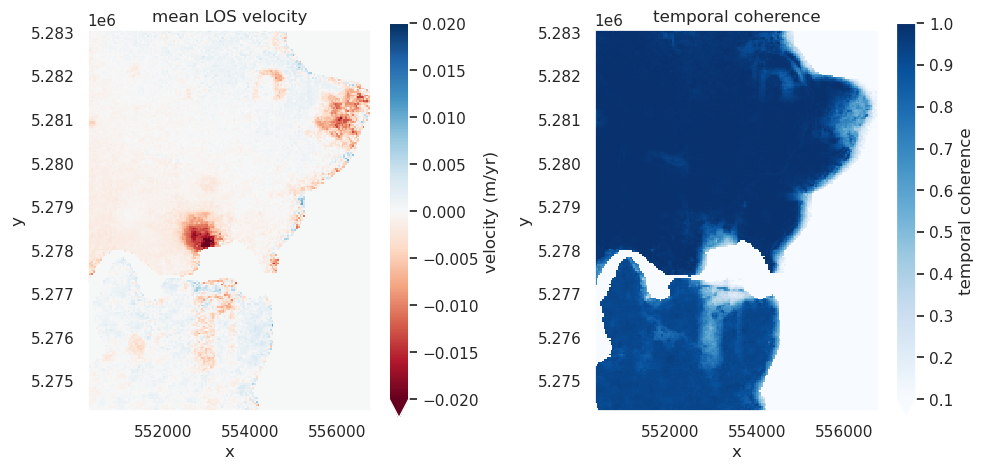

In [146]:
# plot for sanity
sns.set_theme()
f, ax = plt.subplots(1, 2, figsize=(10, 5))
vel_ds.velocity.plot(ax=ax[0], cmap='RdBu', vmin=-0.02, vmax=0.02, 
                     cbar_kwargs={'label':'velocity (m/yr)'})
ax[0].set_title('mean LOS velocity')
ax[0].set_aspect('equal')
tcoh_ds.temporalCoherence.plot(ax=ax[1], cmap='Blues', vmin=0.1, vmax=1, 
                               cbar_kwargs={'label':'temporal coherence'})
ax[1].set_title('temporal coherence')
plt.tight_layout()
ax[1].set_aspect('equal')

plt.savefig('../figs/veloc_maps.png', dpi=300)

In [148]:
# save to geotiff
vel_ds.velocity.rio.to_raster('../proc/mintpy_outputs/veloc.tif')

In [152]:
# load json of aoi 
aoi_gdf = gpd.read_file('../polygons/east_campus.shp')

In [163]:
# change reference points
def change_ref(ds, rref):
    rref_ds = ds.copy(deep=True)
    rref_da = ds.displacement.sel(y=rref[1], x=rref[0], method='nearest')
    rref_ds['displacement'] = ds.displacement - rref_da
    return rref_ds

In [164]:
ts_ds = change_ref(ts_ds, [551852.8,5278304.2])

## Displacement of aoi

In [165]:
# clip to aoi, clip to reference areas
aoi_ds = ts_ds.rio.clip(aoi_gdf.geometry, crs=aoi_gdf.crs, drop=False)

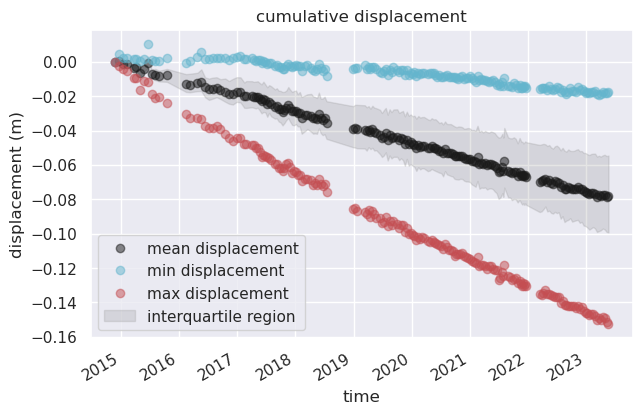

In [195]:
# look at cumulative displacement in aoi and reference area
f, ax = plt.subplots(figsize=(7,4))
aoi_ds.mean(dim=('y', 'x')).displacement.plot(ax=ax, 
                                              label='mean displacement',
                                              c='k', marker='o',
                                              linestyle='',
                                              alpha=0.5)
aoi_ds.max(dim=('y', 'x')).displacement.plot(ax=ax,
                                             label='min displacement',
                                             c='c',
                                             marker='o',
                                             alpha=0.5,
                                             linestyle='')
aoi_ds.min(dim=('y', 'x')).displacement.plot(ax=ax,
                                             label='max displacement',
                                             c='r',
                                             alpha=0.5,
                                             marker='o',
                                             linestyle='')
ax.fill_between(aoi_ds.displacement.quantile(q=0.25, dim=['x', 'y']).time,
                aoi_ds.displacement.quantile(q=0.25, dim=['x', 'y']).values,
                aoi_ds.displacement.quantile(q=0.75, dim=['x', 'y']).values,
                alpha=0.2, color='Grey', label='interquartile region')
ax.set_title('cumulative displacement')
ax.set_ylabel('displacement (m)')
ax.set_xlabel('time')
ax.legend();

plt.savefig('../figs/cum_disp.png', dpi=300)

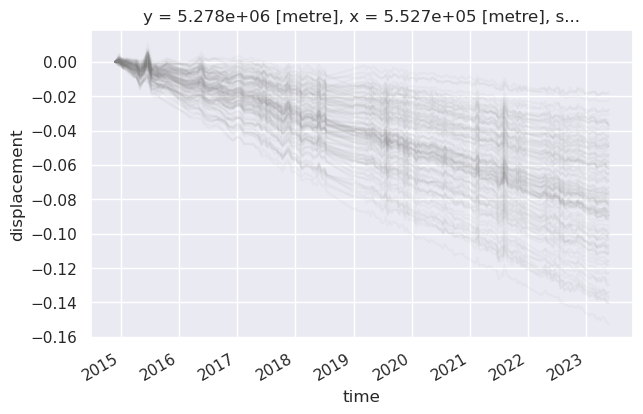

In [199]:
valid_index = np.argwhere(aoi_ds.displacement.median(dim='time').to_numpy() > -10000)
f, ax = plt.subplots(figsize=(7,4))
for i in range(len(valid_index)):
    pixel = aoi_ds.displacement.isel({'y':valid_index[i][0], 'x':valid_index[i][1]})
    pixel.plot(ax=ax, c='Gray', alpha=0.05)